In [1]:
#Import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(style = "darkgrid")
%xmode Plain

Exception reporting mode: Plain


In [2]:
# argument dtype='string' is necessary to avoid warning 'Columns (47) have mixed types'
loan_data = pd.read_csv('loan.csv', dtype='string')

## Data cleaning

In [4]:

# Term: Take the first three digits and convert to integer
loan_data['term'] = loan_data['term'].apply(lambda x: x[0:3]).astype('int32')

# int_rate - Interest rate - Remove % and convert to float
loan_data['int_rate'] = loan_data['int_rate'].apply(lambda x: x.replace('%', '')).astype('float32')

# emp_length: <1 is converted to 1 and >10 is converted to 10
# the function extract_emp_length below performs the conversion
import re
def extract_emp_length(emp_length_field):
    match = re.search(r'\d+', emp_length_field)
    if match:
        return match.group()
    else:
        return None
loan_data['emp_length'].fillna('0', inplace=True)
loan_data['emp_length'] = loan_data['emp_length'].apply(extract_emp_length).astype('int32')

# annual_inc: Some cells contain single quote which needs removal before conversion to integer
loan_data.annual_inc = loan_data.annual_inc.apply(lambda x: x.replace("'", ''))
loan_data.annual_inc = pd.to_numeric(loan_data.annual_inc)

# dti
loan_data.dti = loan_data.dti.astype('float32')

# loan amount
loan_data.loan_amnt = loan_data.loan_amnt.astype('int32')

#installments
loan_data.installment = loan_data.installment.astype('float32')

# delinq in last 2 years
loan_data.delinq_2yrs = pd.to_numeric(loan_data.delinq_2yrs)

# months since last delinq: emptycells and NAs are filled with -1, so that when we analyze we can ignore them
loan_data.mths_since_last_delinq.fillna('-1', inplace=True)
loan_data.mths_since_last_delinq = loan_data.mths_since_last_delinq.apply(lambda x: x.replace('NA', '-1'))
loan_data.mths_since_last_delinq = loan_data.mths_since_last_delinq.astype('int32')

# open credit lines
loan_data.open_acc = loan_data.open_acc.astype('int32')

# number of derogatory public recods
loan_data.pub_rec = loan_data.pub_rec.astype('int32')

# number of public record bankruptcies
loan_data.pub_rec_bankruptcies.fillna('0', inplace=True)
loan_data.pub_rec_bankruptcies = loan_data.pub_rec_bankruptcies.apply(lambda x: x.replace('NA', '0'))
loan_data.pub_rec_bankruptcies = loan_data.pub_rec_bankruptcies.astype('int32')


# chargeoff_within_12_mths: As all values are either 0 or NA, it is not considered 
# collections_12_mths_ex_med: All values are 0, not considered
# grade: Most loans' grades are A, B or C
# home_ownership: Most borrowers either rented or mortgaged their home
# int_rate: Looks to be clean 

loan_data.inq_last_6mths = loan_data.inq_last_6mths.astype('int32')

## Univariate Analysis

#### Annual income

In [7]:
# Min: 4000 and Max 6000000, with mean of 68900. 90% of applicants have income less than 116000
loan_data.annual_inc.describe(percentiles=[.75,.8,.9,.92,.94,.96,.98])

count    3.971700e+04
mean     6.896893e+04
std      6.379377e+04
min      4.000000e+03
50%      5.900000e+04
75%      8.230000e+04
80%      9.000000e+04
90%      1.160000e+05
92%      1.230000e+05
94%      1.350000e+05
96%      1.500000e+05
98%      1.870000e+05
max      6.000000e+06
Name: annual_inc, dtype: float64

In [8]:
# divide income into categories of size 10K

income_bins=[0,10000,20000,30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,np.inf]
income_categories = ['0-10K','10-20K','20-30K','30-40K','40-50K','50K-60K','60K-70K','70K-80K','80K-90K','90K-100K','100K-110K','110K-120K','>120K']

loan_data['income_range'] = pd.cut(loan_data.annual_inc,bins=income_bins,labels=income_categories,include_lowest=True)

#### dti (ratio of total debt payments to annual income)


In [10]:
loan_data.dti.describe(percentiles=[0.8,0.9,0.92,0.94,0.96,0.98])

count    39717.000000
mean        13.315131
std          6.678546
min          0.000000
50%         13.400000
80%         19.750000
90%         22.330000
92%         22.879999
94%         23.500000
96%         24.170000
98%         24.879999
max         29.990000
Name: dti, dtype: float64

In [11]:
# categorize dti into bins of size 4 
dti_bins = [0,4,8,12,16,20,24,np.inf]
dti_buckets = ['0-4','4-8','8-12','12-16','16-20','20-24','>24']
loan_data['dti_categories'] = pd.cut(loan_data.dti, bins=dti_bins, labels=dti_buckets, include_lowest=True)

#### loan amount

In [13]:
#Loan amount: Range is 500-35000, with 94% of samples at or below 25000
loan_data.loan_amnt.describe(percentiles=[.9,.92,.94,.96,.98])

count    39717.000000
mean     11219.443815
std       7456.670694
min        500.000000
50%      10000.000000
90%      22000.000000
92%      24250.000000
94%      25000.000000
96%      25484.000000
98%      31468.000000
max      35000.000000
Name: loan_amnt, dtype: float64

#### term - Duration of loan repayment

In [15]:
# From the csv file, we can see that "term" is either 36 month of 60 month 

#### loan_status - Categorical variable with values 'Charged Off', 'Fully Paid', 'Current'

In [17]:
# loan_status: We see that most samples are either 'Fully Paid' or 'Charged off'.
# For analysis we will compute the % charged off against total in various categories (aka delinquencies or defaults)
loan_data.groupby(['loan_status']).size()

loan_status
Charged Off     5627
Current         1140
Fully Paid     32950
dtype: int64

#### loan amount

In [19]:
# Categorize loan amount into different bins of size 5000
loan_amnt_bins=[0,4000,8000,12000,16000,20000,24000,np.inf]
loan_amnt_categories = ['0-4K','4K-8K','8K-12K','12K-16K','16K-20K','20K-24K','>24K']
loan_data['loan_amnt_bucket'] = pd.cut(loan_data.loan_amnt,bins=loan_amnt_bins,labels=loan_amnt_categories,include_lowest=True)

#### interest rate

In [21]:
loan_data.int_rate.describe()

count    39717.000000
mean        12.021177
std          3.724828
min          5.420000
25%          9.250000
50%         11.860000
75%         14.590000
max         24.590000
Name: int_rate, dtype: float64

In [22]:
# categorize interest rate into  buckets of size 2% 
int_rate_bins=[0,2,4,6,8,10,12,14,16,18,20,np.inf]
int_rate_categories = ['0-2','2-4','4-6','6-8','8-10','10-12','12-14','14-16','16-18','18-20','>20']
loan_data['int_rate_bucket'] = pd.cut(loan_data.int_rate,bins=int_rate_bins,labels=int_rate_categories,include_lowest=True)

#### installment

In [24]:
# installment: 95% of values are < 800
loan_data.installment.describe(percentiles=[0.6,0.7,0.8,0.9,0.95])

count    39717.000000
mean       324.561920
std        208.874756
min         15.690000
50%        280.220001
60%        330.641998
70%        389.359985
80%        483.380005
90%        622.951990
95%        762.996008
max       1305.189941
Name: installment, dtype: float64

In [25]:
# categorize installment into buckets of size 200 upto 800
installment_bins=[0,100,200,300,400,500,600,700,800,np.inf]
installment_categories = ['0-100','100-200','200-300','300-400','400-500','500-600','600-700','700-800','>800']
loan_data['installment_bucket'] = pd.cut(loan_data.installment,bins=installment_bins,labels=installment_categories,include_lowest=True)

#### months since last delinq - The number of months since the borrower's last delinquency.

In [27]:
# Since we replaced many empty cells and NAs with -1, we explore its distribution excluding the -1s
loan_data.mths_since_last_delinq[loan_data.mths_since_last_delinq != -1].describe(percentiles=[0.8,0.9,0.95,0.99])

count    14035.000000
mean        35.900962
std         22.020060
min          0.000000
50%         34.000000
80%         57.000000
90%         69.000000
95%         75.000000
99%         81.000000
max        120.000000
Name: mths_since_last_delinq, dtype: float64

In [28]:
# Based on the above distribution, we categorize mths_since_last_delinq into buckets of size 10 each upto 80
delinq_nonzero_months = loan_data.mths_since_last_delinq != -1
msld_bins = [-1,0,10,20,30,40,50,60,70,80,np.inf]
msld_cat = ['-1','0-10','11-20','21-30','31-40','41-50','51-60','61-70','71-80','>80']

loan_data['msld_bucket'] = pd.cut(loan_data.mths_since_last_delinq, bins=msld_bins, labels=msld_cat, include_lowest=True)

#### open_acc - The number of open credit lines in the borrower's credit file.

In [30]:
# open_acc
loan_data.open_acc.describe()

count    39717.000000
mean         9.294408
std          4.400282
min          2.000000
25%          6.000000
50%          9.000000
75%         12.000000
max         44.000000
Name: open_acc, dtype: float64

In [31]:
# it was observed that for open_acc > 20, there were very few loans and delinquencies
# hence we categorize open_acc from 0-20 in intervals of 4 each
open_acc_bins = [0,4,8,12,16,20,np.inf]
open_acc_cat = ['0-4','5-8','9-12','13-16','17-20','>20']

loan_data['open_acc_bucket'] = pd.cut(loan_data.open_acc, bins=open_acc_bins, labels=open_acc_cat, include_lowest=True)

#### Now we analyze the impact of the above variables on delinquencies which is the target for the business problem.
#### We compute the percentage delinquencies out of the Total number of loans, and compare how each variable affects it. 
#### Apart from that some more categorical variables are derived from continuous variables - please see cell below

In [33]:
# NOTE:
# For this analysis, we have already derived categorical variables from continuous variables for the below variables: 
    # Annual income
    # dti (ratio of total debt payments to annual income)
    # loan amount, 
    # installment, 
    # months since last delinquency, 
    # number of open credit lines

In [34]:
# This is a condition applied to segment the loan data entries based on whether it is delinquent or n ot
chargedoff = loan_data.loan_status == 'Charged Off'

In [35]:
# This function is used to plot bar chart showing relation between %delinquencies (on Y axis) and specified metric on X axis
# The metric specified should be present in loan_data
def metric_vs_delinquencies_bar_plot(loan_data_df, metric_name, total_bar=True):
    deliquent_metric_categories = loan_data_df[chargedoff].groupby(metric_name, observed=False).size().reset_index(name='ChargedOff')
    loan_data_metric_categories = loan_data_df.groupby(metric_name, observed=False).size().reset_index(name='Total')
    loan_data_metric_categories_combined = pd.merge(deliquent_metric_categories, loan_data_metric_categories, on=metric_name)
    loan_data_metric_categories_combined['percent_chargedoff'] = deliquent_metric_categories['ChargedOff']*100/loan_data_metric_categories['Total']
    if total_bar == True:
        loan_data_metric_categories_combined[[metric_name,'ChargedOff','Total']].plot.bar(x=metric_name, figsize=(6,3))
    loan_data_metric_categories_combined[[metric_name,'percent_chargedoff']].plot.bar(x=metric_name, figsize=(6,3))
    plt.show()

#### correlation between annual income and %delinquencies

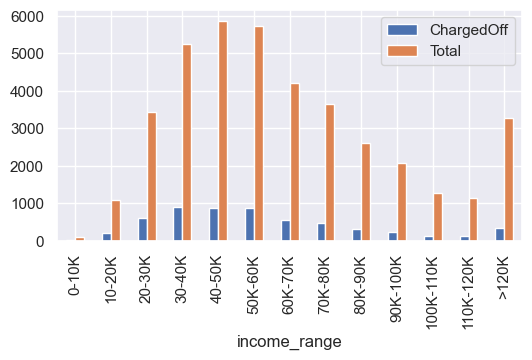

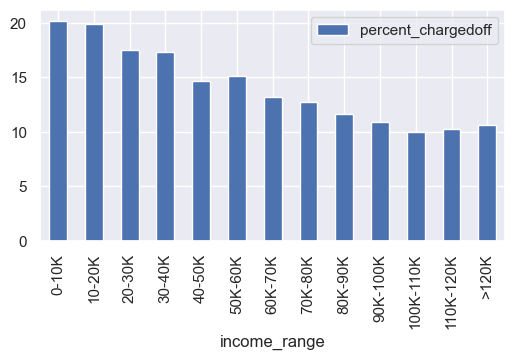

In [37]:
metric_vs_delinquencies_bar_plot(loan_data, 'income_range')

%delinquencies reduce as income range goes up

#### correlation between dti categories and percentage of delinquencies

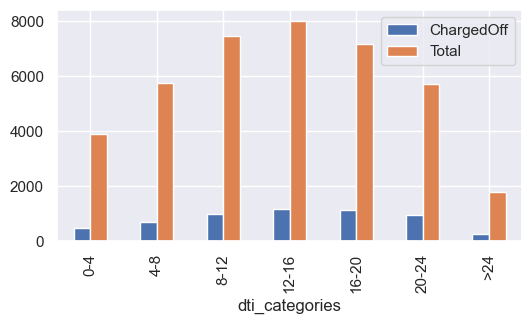

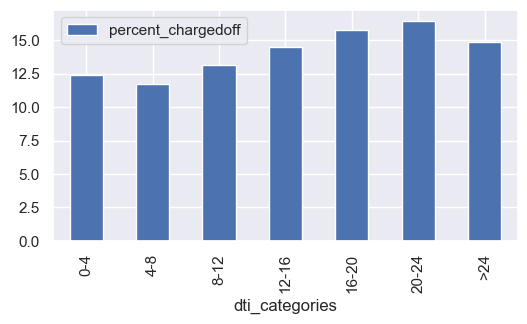

In [40]:
metric_vs_delinquencies_bar_plot(loan_data, 'dti_categories')

Correlation between %delinquencies and dti is less than the correlation between %delinquencies and annual income.
Therefore we will explore annual income as the driving factor and ignore dti in further analysis

#### Correlation between loan term and delinquencies

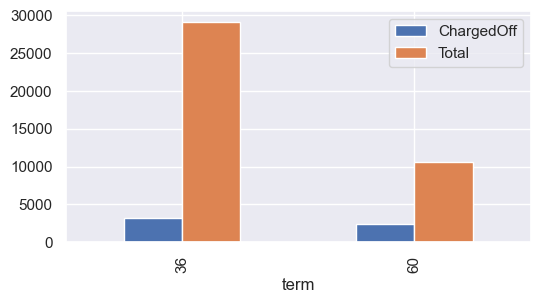

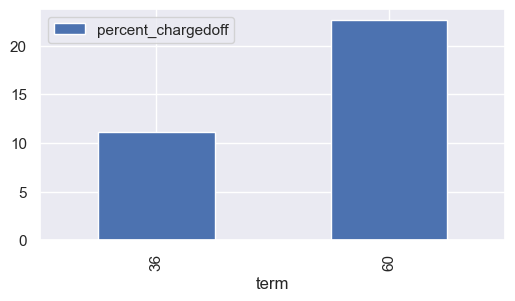

In [43]:
metric_vs_delinquencies_bar_plot(loan_data, 'term')

%defaults are almost twice for 60month term compared to 30month term

#### Correlation of delinq_2yrs with percentage of delinquencies

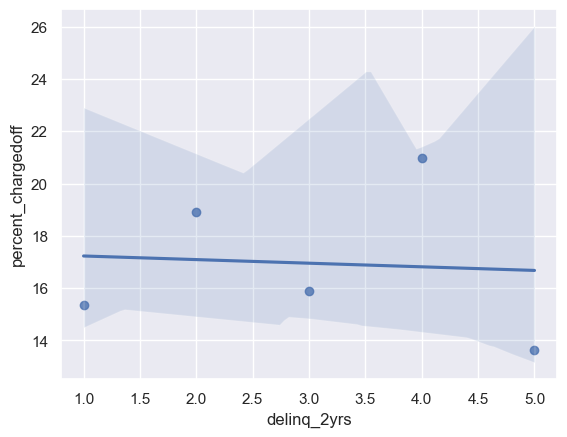

In [46]:
# It is observed that for values 6 and above there are very small number of samples
# hence we limit the range of this variable to 0-5 for analysis
delinq_2yrs_nonzero = loan_data.delinq_2yrs > 0
delinq_2yrs_lt6 = loan_data.delinq_2yrs < 6
# Not using the custom function metric_vs_delinquencies_bar_plot as we want to use seaborn regplot 
charged_off_delinq_2yrs_categories = loan_data[chargedoff & delinq_2yrs_nonzero & delinq_2yrs_lt6].groupby('delinq_2yrs').size().reset_index(name='ChargedOff')
loan_data_delinq_2yrs_categories = loan_data[delinq_2yrs_nonzero & delinq_2yrs_lt6].groupby('delinq_2yrs').size().reset_index(name='Total')
loan_data_delinq_2yrs_categories_combined = pd.merge(charged_off_delinq_2yrs_categories, loan_data_delinq_2yrs_categories, on='delinq_2yrs')
loan_data_delinq_2yrs_categories_combined['percent_chargedoff'] = loan_data_delinq_2yrs_categories_combined['ChargedOff']*100/loan_data_delinq_2yrs_categories_combined['Total']

loan_data_delinq_2yrs_categories_combined.percent_chargedoff = loan_data_delinq_2yrs_categories_combined.percent_chargedoff.astype('float64')
loan_data_delinq_2yrs_categories_combined.delinq_2yrs = loan_data_delinq_2yrs_categories_combined.delinq_2yrs.astype('float64')
sns.regplot(data=loan_data_delinq_2yrs_categories_combined, x='delinq_2yrs', y='percent_chargedoff')
plt.show()

There is no significant variation of defaults in relation to 'The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years'

In [48]:
# Correlation of months_since_last_delinq with percentage of defaults

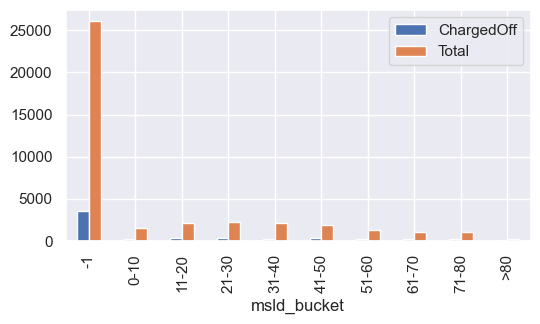

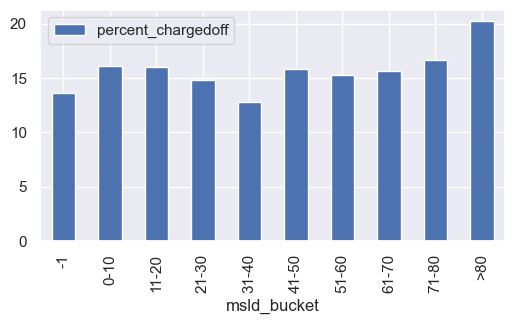

In [49]:
metric_vs_delinquencies_bar_plot(loan_data, 'msld_bucket')

For value above 80, the number of samples is very small, hence we cannot consider the same in the analysis.
There is no significant variation of defaults in relation to 'The number of months since the borrower's last delinquency.'

In [51]:
# correlation between open_acc and defaults

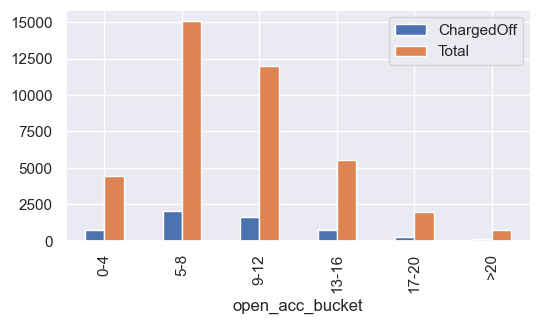

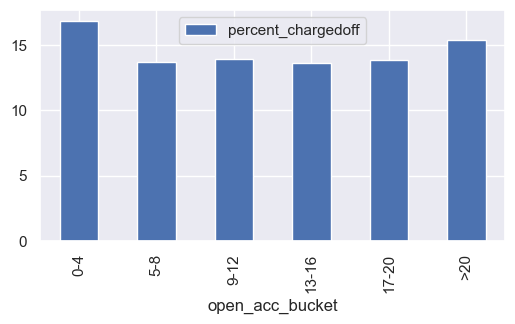

In [52]:
metric_vs_delinquencies_bar_plot(loan_data, 'open_acc_bucket')

There is no significant variation of defaults in relation to 'The number of open credit lines in the borrower's credit file.'

#### correlation between number of bankruptices (pub_rec_bankruptcies) with %defaults

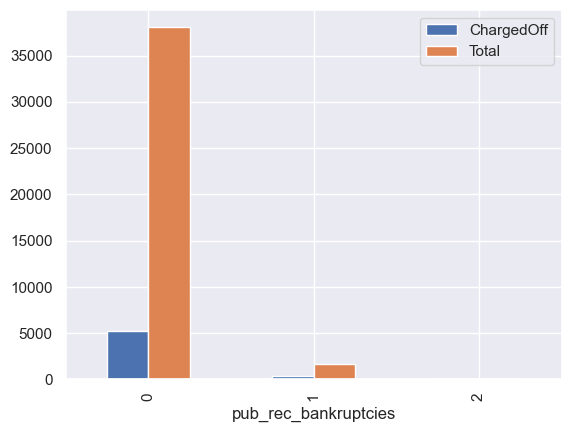

In [55]:
# Plotting the total and deliquencies for each value of pub_rec_bankruptcies
charged_off_pub_rec_b_categories = loan_data[loan_data.loan_status == 'Charged Off'].groupby('pub_rec_bankruptcies').size().reset_index(name='ChargedOff')
loan_data_pub_rec_b_categories = loan_data.groupby('pub_rec_bankruptcies').size().reset_index(name='Total')
loan_data_pub_rec_b_categories_combined = pd.merge(charged_off_pub_rec_b_categories, loan_data_pub_rec_b_categories, on='pub_rec_bankruptcies')
loan_data_pub_rec_b_categories_combined['percent_chargedoff'] = charged_off_pub_rec_b_categories['ChargedOff']*100/loan_data_pub_rec_b_categories['Total']
loan_data_pub_rec_b_categories_combined[['pub_rec_bankruptcies','ChargedOff','Total']].plot.bar(x='pub_rec_bankruptcies')
#loan_data_pub_rec_b_categories_combined[['pub_rec_bankruptcies','percent_chargedoff']].plot.bar(x='pub_rec_bankruptcies')
plt.show()

There are very few loans for which 'Number of public records of bankruptcies' is > 0, hence it is not considered in the analysis

#### correlation between loan verification status and %defaults

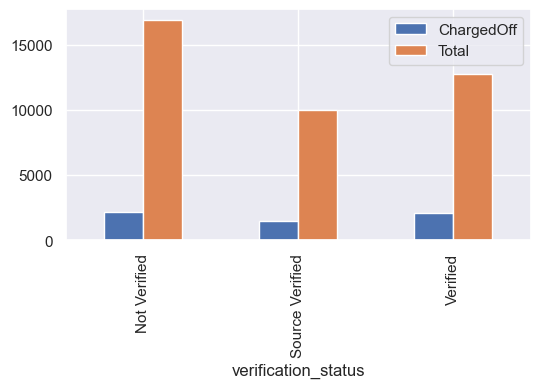

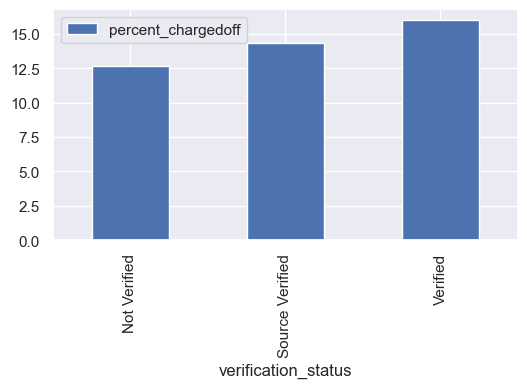

In [58]:
metric_vs_delinquencies_bar_plot(loan_data, 'verification_status')

it is interesting that verification of income status does not lead to less defaults.

#### correlation of home_ownership with %defaults

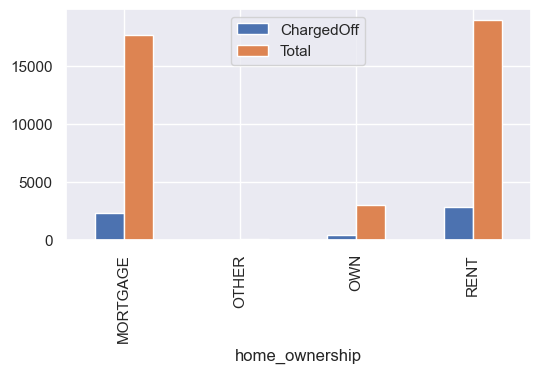

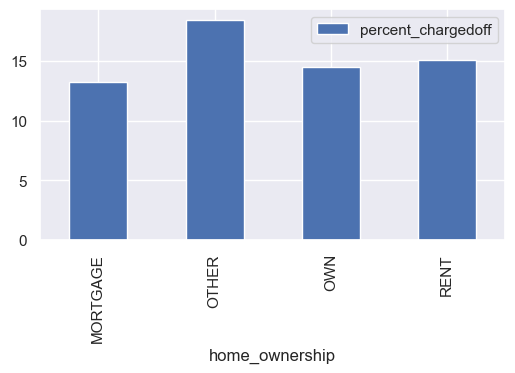

In [61]:
loan_data['home_ownership'] = pd.Categorical(loan_data['home_ownership'])
loan_data['home_ownership'] = loan_data['home_ownership'].cat.remove_categories('NONE')
metric_vs_delinquencies_bar_plot(loan_data, 'home_ownership', total_bar=True)
plt.show()

The number of samples for 'Other' is very small, so we cannot consider it in analysis.
There is no significant variation of defaults in relation the home ownership category of applicants

#### correlation between employment length and %defaults

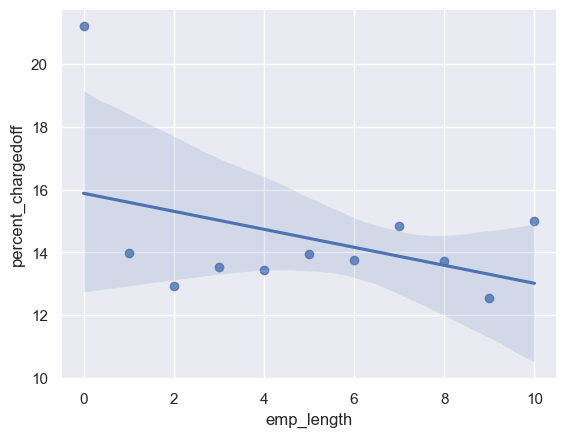

In [64]:
charged_off_el_categories = loan_data[chargedoff].groupby('emp_length').size().reset_index(name='ChargedOff')
loan_data_el_categories = loan_data.groupby('emp_length').size().reset_index(name='Total')
loan_data_el_categories_combined = pd.merge(charged_off_el_categories, loan_data_el_categories, on='emp_length')
#loan_data_el_categories_combined[['ChargedOff','Total','emp_length']].plot.bar(x='emp_length')
loan_data_el_categories_combined['percent_chargedoff'] = loan_data_el_categories_combined['ChargedOff']*100/loan_data_el_categories_combined['Total']
#loan_data_el_categories_combined[['percent_chargedoff','emp_length']].plot.bar(x='emp_length')
loan_data_el_categories_combined.percent_chargedoff = loan_data_el_categories_combined.percent_chargedoff.astype('float64')
loan_data_el_categories_combined.emp_length = loan_data_el_categories_combined.emp_length.astype('float64')
sns.regplot(data=loan_data_el_categories_combined, x='emp_length', y='percent_chargedoff')
plt.show()

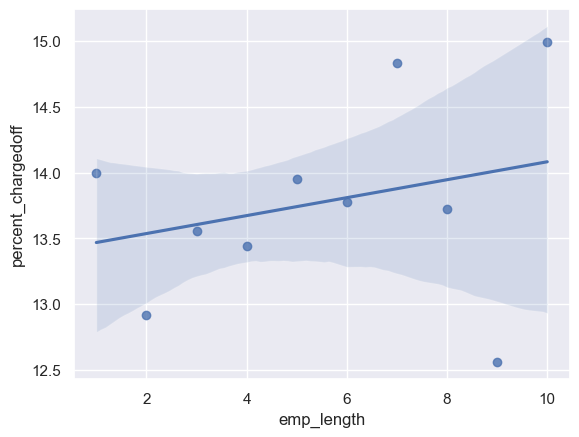

In [65]:
# As emp_length <=0 appears like an outlier, exclude it and again plot correlation between employment length and %defaults
sns.regplot(data=loan_data_el_categories_combined[loan_data_el_categories_combined.emp_length>0], x='emp_length', y='percent_chargedoff')
plt.show()

Defaults are much higher for applications employed for <= 1 year compared to all other numbers of employment length. If we exclude emp_length 0,  there is no significant correlation.

#### correlation between interest rate categories and delinquencies

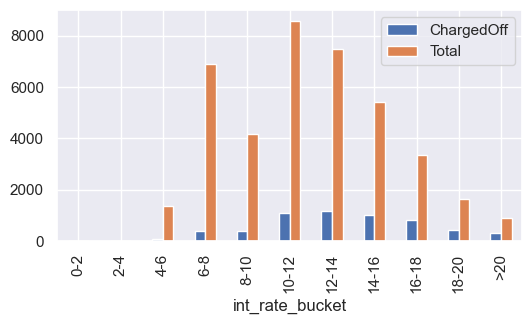

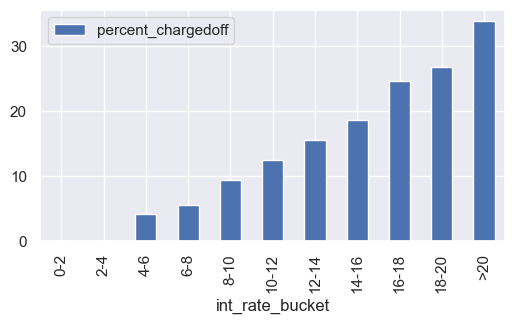

In [68]:
metric_vs_delinquencies_bar_plot(loan_data, 'int_rate_bucket')

defaults are higher for higher interest rate loans, almost linearly

#### correlation between number of derogatory public records and delinquencies

C:\Users\bhadrava\AppData\Local\Temp\ipykernel_34712\4014106489.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  deliquent_metric_categories = loan_data_df[chargedoff].groupby(metric_name, observed=False).size().reset_index(name='ChargedOff')


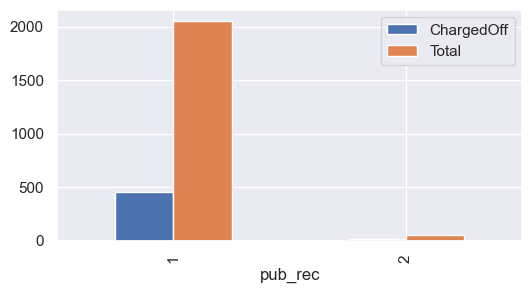

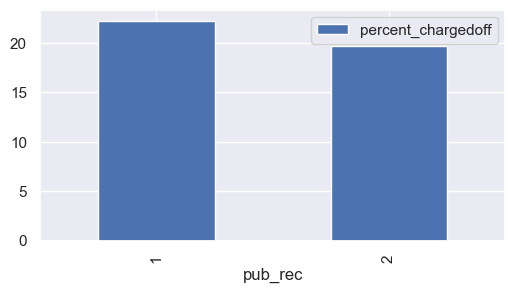

In [74]:
loan_data_pub_rec = loan_data[loan_data.pub_rec>0]
metric_vs_delinquencies_bar_plot(loan_data_pub_rec, 'pub_rec')

We do not see significant variation for pub_rec

#### correlation between 'inquiries since last 6 months' and delinquencies

In [ ]:
# We are using 0-4 as there are very few samples above 4
inq_last_6mths_lt5 = loan_data.inq_last_6mths <= 4
loan_data_fc2 = loan_data[inq_last_6mths_lt5]
metric_vs_delinquencies_bar_plot(loan_data_fc2, 'inq_last_6mths')

loan default rate is higher for applicants who have made more inquiries in past 6 months

#### correlation between loan amount categories and delinquencies

In [ ]:
metric_vs_delinquencies_bar_plot(loan_data, 'loan_amnt_bucket')

the number of defaults increase almost linearly in relation to the loan amount

#### correlation between installment categories and delinquencies

In [ ]:
metric_vs_delinquencies_bar_plot(loan_data, 'installment_bucket')

No significant variation in default rate with the loan installment amount.
However we see slightly better information when correlate both installment and income range

## Bivariate analysis

#### variation of %defaults against both loan term & income buckets

In [ ]:
chargedoff = loan_data.loan_status == 'Charged Off'
loan_data_term_ib_categories = loan_data[chargedoff].groupby(['term', 'income_range'], observed=False).size().reset_index(name='Chargedoff')
loan_data_term_ib_cat_total = loan_data.groupby(['term', 'income_range'], observed=False).size().reset_index(name='Total')
term_ib_percent = pd.merge(loan_data_term_ib_categories, loan_data_term_ib_cat_total, on=['term', 'income_range'])
term_ib_percent['Percent_Chargedoff'] = term_ib_percent['Chargedoff']*100/term_ib_percent['Total']
pv = pd.pivot_table(data=term_ib_percent, index='income_range', columns='term', values='Percent_Chargedoff')
sns.heatmap(pv, cmap="Reds", annot=True)
plt.show()

%defaults are higher for 60month term loans for all income ranges compared to 36month. Also it is higher for lower income ranges. Both these are inline with the previous correlation study of income range and term against default rate

#### variation of %defaults against both verification status and income

In [ ]:
loan_data_income_bucket_vs_categories = loan_data[chargedoff].groupby(['income_range', 'verification_status'], observed=False).size().reset_index(name='Chargedoff')
loan_data_income_bucket_vs_cat_total = loan_data.groupby(['income_range', 'verification_status'], observed=False).size().reset_index(name='Total')
income_bucket_vs_percent = pd.merge(loan_data_income_bucket_vs_categories, loan_data_income_bucket_vs_cat_total, on=['income_range', 'verification_status'])
income_bucket_vs_percent['Percent_Chargedoff'] = income_bucket_vs_percent['Chargedoff']*100/income_bucket_vs_percent['Total']
pv = pd.pivot_table(data=income_bucket_vs_percent, index='income_range', columns='verification_status', values='Percent_Chargedoff')
sns.heatmap(pv, cmap="Reds", annot=True)
plt.show()

Except very low income range 0-10K, income verification is not useful as it does not have help in identifying potential loan defaults.

deliquency vs term+verifiation_status - This does not give any new insight,  hence not included

#### Variation of %default vs both annual income and installment amount

In [ ]:
loan_data_income_bucket_ic_categories = loan_data[chargedoff].groupby(['income_range', 'installment_bucket'], observed=False).size().reset_index(name='Chargedoff')
loan_data_income_bucket_ic_cat_total = loan_data.groupby(['income_range', 'installment_bucket'], observed=False).size().reset_index(name='Total')
income_bucket_ic_percent = pd.merge(loan_data_income_bucket_ic_categories, loan_data_income_bucket_ic_cat_total, on=['income_range', 'installment_bucket'])
income_bucket_ic_percent['Percent_Chargedoff'] = income_bucket_ic_percent['Chargedoff']*100/income_bucket_ic_percent['Total']
pv = pd.pivot_table(data=income_bucket_ic_percent, index='income_range', columns='installment_bucket', values='Percent_Chargedoff')
sns.heatmap(pv, cmap="Reds", annot=True)
plt.show()

For income ranges from 10-60K, reducing the maximum installment amount by 200-400 could reduce default rate significantly

#### Variation of %default vs both annual income and loan amount

In [ ]:
loan_data_income_bucket_lab_categories = loan_data[chargedoff].groupby(['income_range', 'loan_amnt_bucket'], observed=False).size().reset_index(name='Chargedoff')
loan_data_income_bucket_lab_cat_total = loan_data.groupby(['income_range', 'loan_amnt_bucket'], observed=False).size().reset_index(name='Total')
income_bucket_lab_percent = pd.merge(loan_data_income_bucket_lab_categories, loan_data_income_bucket_lab_cat_total, on=['income_range', 'loan_amnt_bucket'])
income_bucket_lab_percent['Percent_Chargedoff'] = income_bucket_lab_percent['Chargedoff']*100/income_bucket_lab_percent['Total']
pv = pd.pivot_table(data=income_bucket_lab_percent, index='income_range', columns='loan_amnt_bucket', values='Percent_Chargedoff')
sns.heatmap(pv, cmap="Reds", annot=True)
plt.show()

For income ranges upto 60K, reducing the maximum loan amount by 4-8K could reduce default rates significantly


#### other correlations 

In [ ]:
loan_data_lab_term_categories = loan_data[chargedoff].groupby(['loan_amnt_bucket', 'term'], observed=False).size().reset_index(name='Chargedoff')
loan_data_lab_term_cat_total = loan_data.groupby(['loan_amnt_bucket', 'term'], observed=False).size().reset_index(name='Total')
lab_term_percent = pd.merge(loan_data_lab_term_categories, loan_data_lab_term_cat_total, on=['loan_amnt_bucket', 'term'])
lab_term_percent['Percent_Chargedoff'] = lab_term_percent['Chargedoff']*100/lab_term_percent['Total']
pv = pd.pivot_table(data=lab_term_percent, index='loan_amnt_bucket', columns='term', values='Percent_Chargedoff')
sns.heatmap(pv, cmap="Reds", annot=True)
plt.show()

Again, longer term (60 months) consistently leads to higher loan default rate irrespective of loan amount

In [ ]:
loan_data_lab_vs_categories = loan_data[chargedoff].groupby(['loan_amnt_bucket', 'verification_status'], observed=False).size().reset_index(name='Chargedoff')
loan_data_lab_vs_cat_total = loan_data.groupby(['loan_amnt_bucket', 'verification_status'], observed=False).size().reset_index(name='Total')
lab_vs_percent = pd.merge(loan_data_lab_vs_categories, loan_data_lab_vs_cat_total, on=['loan_amnt_bucket', 'verification_status'])
lab_vs_percent['Percent_Chargedoff'] = lab_vs_percent['Chargedoff']*100/lab_vs_percent['Total']
pv = pd.pivot_table(data=lab_vs_percent, index='loan_amnt_bucket', columns='verification_status', values='Percent_Chargedoff')
sns.heatmap(pv, cmap="Reds", annot=True)
plt.show()

Again, there is hardly any effect of loan verification with %defaults

In [ ]:
loan_data_ib_vs_categories = loan_data[chargedoff].groupby(['installment_bucket', 'verification_status'], observed=False).size().reset_index(name='Chargedoff')
loan_data_ib_vs_cat_total = loan_data.groupby(['installment_bucket', 'verification_status'], observed=False).size().reset_index(name='Total')
ib_vs_percent = pd.merge(loan_data_ib_vs_categories, loan_data_ib_vs_cat_total, on=['installment_bucket', 'verification_status'])
ib_vs_percent['Percent_Chargedoff'] = ib_vs_percent['Chargedoff']*100/ib_vs_percent['Total']
pv = pd.pivot_table(data=ib_vs_percent, index='installment_bucket', columns='verification_status', values='Percent_Chargedoff')
sns.heatmap(pv, cmap="Reds", annot=True)
plt.show()
